In [1]:
import sys
sys.path.append('../gtm/')
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from corpus import GTMCorpus
from gtm import GTM
from random import random

# ----- Document generation -----

def generate_doc(i, true_doc_topic_matrix, topic_word_matrices, min_words, max_words, language):
    doc_length = np.random.randint(min_words, max_words + 1)
    doc_topic_vector = true_doc_topic_matrix[i]
    doc_words = []
    topic_word_matrix = topic_word_matrices[language]
    vocab_size = topic_word_matrix.shape[1]
    for _ in range(doc_length):
        word_probs = np.dot(doc_topic_vector, topic_word_matrix)
        word_probs /= word_probs.sum()
        word_index = np.random.choice(vocab_size, p=word_probs)
        doc_words.append(f"{language}_word_{word_index}")
    return " ".join(doc_words)

def generate_documents(
    num_docs,
    num_topics,
    vocab_size,
    num_covs,
    lambda_,
    sigma,
    doc_topic_prior,
    min_words,
    max_words,
    random_seed,
    align_proportion=0.1
):
    np.random.seed(random_seed)
    topicnames = [f"Topic{i}" for i in range(num_topics)]
    cov_names = [f"cov_{i}" for i in range(num_covs + 1)]
    words = {
        'lang1': [f"lang1_word_{i}" for i in range(vocab_size)],
        'lang2': [f"lang2_word_{i}" for i in range(vocab_size)]
    }

    # Prevalence covariates
    if num_covs > 0:
        M_prevalence_covariates = np.zeros((num_docs, num_covs + 1), dtype=int)
        M_prevalence_covariates[:, 0] = 1
        for i in range(num_covs):
            M_prevalence_covariates[:, i + 1] = np.random.randint(2, size=num_docs)

    # Topic proportions
    if num_covs > 0:
        alpha = np.exp(M_prevalence_covariates @ lambda_)
    else:
        alpha = np.full((num_docs, num_topics), 0.1)

    if doc_topic_prior == 'dirichlet':
        true_doc_topic_matrix = np.array([np.random.dirichlet(a) for a in alpha])
    else:
        if num_covs > 0:
            mean = M_prevalence_covariates @ lambda_
        else:
            mean = np.zeros((num_docs, num_topics))
        true_doc_topic_matrix = np.array([
            np.exp(np.random.multivariate_normal(m, sigma)) for m in mean
        ])
        true_doc_topic_matrix /= true_doc_topic_matrix.sum(axis=1, keepdims=True)

    topic_word_matrices = {
        'lang1': np.random.dirichlet([0.1] * vocab_size, num_topics),
        'lang2': np.random.dirichlet([0.1] * vocab_size, num_topics)
    }

    # Generate docs
    documents_lang1, documents_lang2, groups, doc_topic_rows = [], [], [], []
    aligned_indices = np.random.choice(num_docs, int(num_docs * align_proportion), replace=False)

    for i in tqdm(range(num_docs)):
        if i in aligned_indices:
            doc1 = generate_doc(i, true_doc_topic_matrix, topic_word_matrices, min_words, max_words, 'lang1')
            doc2 = generate_doc(i, true_doc_topic_matrix, topic_word_matrices, min_words, max_words, 'lang2')
            documents_lang1.append(doc1)
            documents_lang2.append(doc2)
        else:
            lang = np.random.choice(['lang1', 'lang2'])
            doc = generate_doc(i, true_doc_topic_matrix, topic_word_matrices, min_words, max_words, lang)
            if lang == 'lang1':
                documents_lang1.append(doc)
                documents_lang2.append(None)
            else:
                documents_lang1.append(None)
                documents_lang2.append(doc)
        groups.append(i)
        doc_topic_rows.append(true_doc_topic_matrix[i])

    df = pd.DataFrame({"doc_clean_1": documents_lang1, "doc_clean_2": documents_lang2})
    if num_covs > 0:
        df = pd.concat([df, pd.DataFrame(M_prevalence_covariates, columns=cov_names)], axis=1)

    return pd.DataFrame(doc_topic_rows, columns=topicnames), df

# ----- Simulate data -----

df_true_dist, df = generate_documents(
    num_docs=10000,
    num_topics=2,
    vocab_size=500,
    num_covs=0,
    lambda_=np.random.randn(2, 2),
    sigma=np.eye(2),
    doc_topic_prior='logistic_normal',
    min_words=100,
    max_words=100,
    random_seed=42,
    align_proportion=1.0
)

# ----- Corpus + GTM -----
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_lang1 = CountVectorizer()
vectorizer_lang1.fit(df["doc_clean_1"]) 

vectorizer_lang2 = CountVectorizer()
vectorizer_lang2.fit(df["doc_clean_2"]) 

modalities = {
    "lang1": {
        "column": "doc_clean_1",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer_lang1
            }
        }
    },
    "lang2": {
        "column": "doc_clean_2",
        "views": {
            "bow": {
                "type": "bow",
                "vectorizer": vectorizer_lang2
            }
        }
    }
}

train_dataset = GTMCorpus(df, modalities=modalities)

tm = GTM(
    train_data=train_dataset,
    n_topics=2,
    doc_topic_prior="logistic_normal",
    encoder_input=["lang1_bow", "lang2_bow"],
    decoder_input=["lang1_bow", "lang2_bow"],
    print_topics=False,
    dropout=0,
    batch_size=64
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 273.96it/s]



Epoch   1	Mean Training Loss:12.1669722


Epoch   2	Mean Training Loss:11.7021549


Epoch   3	Mean Training Loss:11.3494944


Epoch   4	Mean Training Loss:11.0837023


Epoch   5	Mean Training Loss:10.8458000


Epoch   6	Mean Training Loss:10.6319065


Epoch   7	Mean Training Loss:10.4501493


Epoch   8	Mean Training Loss:10.2960274


Epoch   9	Mean Training Loss:10.1604836


Epoch  10	Mean Training Loss:10.0462942


Epoch  11	Mean Training Loss:9.9563764


Epoch  12	Mean Training Loss:9.8587256


Epoch  13	Mean Training Loss:9.8074716


Epoch  14	Mean Training Loss:9.7529740


Epoch  15	Mean Training Loss:9.6911084


Epoch  16	Mean Training Loss:9.6331861


Epoch  17	Mean Training Loss:9.6033495


Epoch  18	Mean Training Loss:9.5723657


Epoch  19	Mean Training Loss:9.5477716


Epoch  20	Mean Training Loss:9.5223359


Epoch  21	Mean Training Loss:9.4891608


Epoch  22	Mean Training Loss:9.4816725


Epoch  23	Mean Training Loss:9.4553997


Epoch  24	Mean Training Loss:9.4493561


Epoch

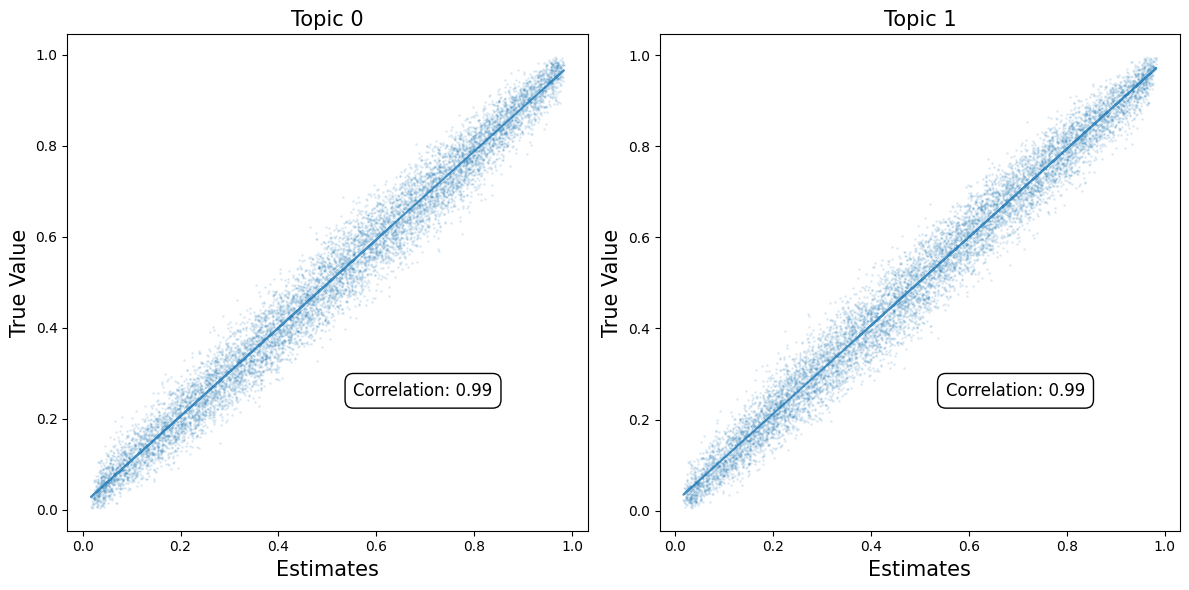

In [2]:
estimated_doc_topics = tm.get_doc_topic_distribution(train_dataset, num_samples=30)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):  
    x = estimated_doc_topics[:, i]  
    y = df_true_dist['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, s=1, alpha=0.1)
    
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), alpha=0.8)
    
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title(f'Topic {i}', fontsize=15)

    corr_coeff = np.corrcoef(x, y)[0, 1]
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                    fontsize=12, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()

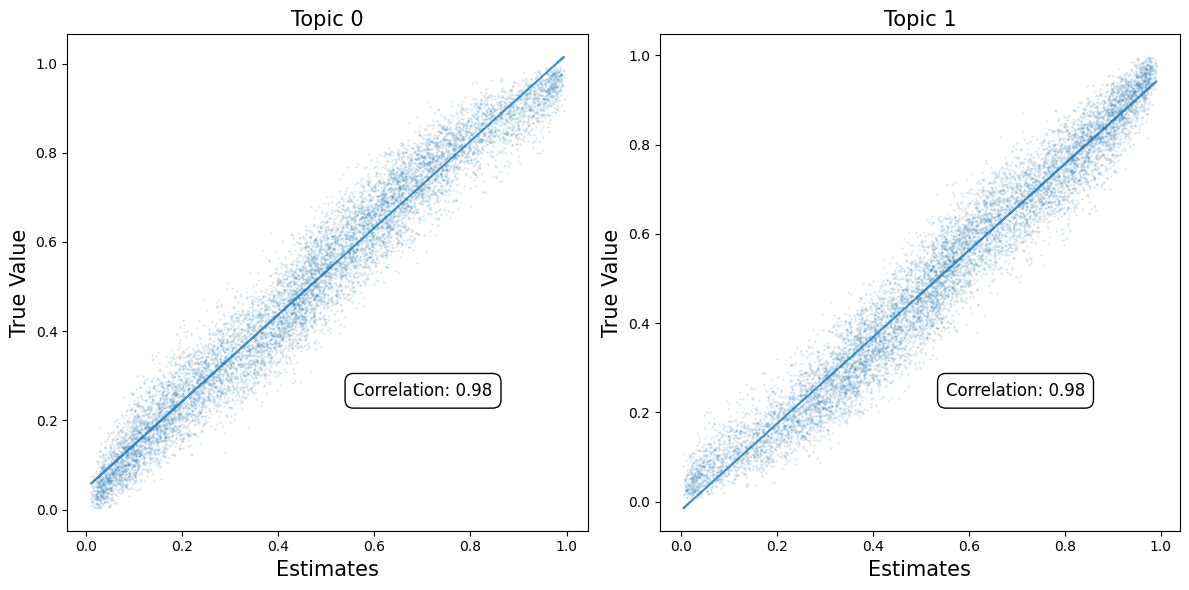

In [3]:
estimated_doc_topics = tm.get_doc_topic_distribution(train_dataset, single_modality="lang1_bow", num_samples=30)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):  
    x = estimated_doc_topics[:, i]  # or 1 - estimated_doc_topics[:, i] if that's your intention
    y = df_true_dist['Topic{}'.format(i)]
    
    axs[i].scatter(x, y, s=1, alpha=0.1)
    
    coefficients = np.polyfit(x, y, 1)
    fit = np.poly1d(coefficients)
    axs[i].plot(x, fit(x), alpha=0.8)
    
    axs[i].set_xlabel('Estimates', fontsize=15)
    axs[i].set_ylabel('True Value', fontsize=15)
    axs[i].set_title(f'Topic {i}', fontsize=15)

    corr_coeff = np.corrcoef(x, y)[0, 1]
    axs[i].annotate(f'Correlation: {corr_coeff:.2f}', xy=(0.55, 0.3), xycoords='axes fraction',
                    fontsize=12, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()